# Star Selection Function and Examples

Make the necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table
from scipy.spatial import distance
from scipy import spatial
from scipy.spatial import KDTree
import time
import matplotlib.path as mpltPath
from matplotlib.patches import Circle, Wedge, Polygon

Read in the data for the region you wish to analyse. Use the standard methods.
For this example, I will be reading in a region of the sky containing CHAMII and CHAMIII

In [2]:
t = Table.read('cloud_data.vot',format='votable')
print(t.colnames) #To be able to know column names within VOTable

RA = t['RA_ICRS']
DEC = t['DE_ICRS']
Gmag = t['__Gmag_']

WARNING

['_RAJ2000', '_DEJ2000', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'pmRA', 'pmDE', 'RADEcor', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var']


: W51: cloud_data.vot:125:122: W51: Value '4631295980108169216' is out of range for a 16-bit integer field [astropy.io.votable.converters]


First, we define the data that we are going to use in the Analysis.
'data' represents our RA and DEC coordinates for all stars within the region.
'redData' Represents all stars with Gmag Less than 17  (G <=17)

In [3]:
data = np.array([RA,DEC])
redData = []
for i in range(len(Gmag)):
    if(Gmag[i] <= 17.0):
        redData.append([RA[i],DEC[i]])
#data = np.array([RA2,DEC2])
data = np.array(data)
redData = np.array(redData)
print((data[0]))
data = np.transpose(data)
print(len(data))
#print(data[30000])
print(redData[0,1])

[ 13.40479395  13.36357079  13.49955861 ...,  13.27403643  13.27086827
  13.20184227]
6860
-80.4873302854


The following code defines the function "distanceMap'. It will use the KDTree Nearest Neighbor algorithm to create a distance map for all of the stars in the selected region. With this distance map, it will create a contour plot to reveal the 2D structure of the cloud or clouds. It will also define a matrix called 'DistArray', and this matrix will be used for the Star Selection function. 

In [7]:
def distanceMap(N,data,k):
    Start = time.time()
    

    xgrid = np.linspace(np.min(data[:,0]),np.max(data[:,0]),N)
    ygrid = np.linspace(np.min(data[:,1]),np.max(data[:,1]),N)
    X, Y = np.meshgrid(xgrid,ygrid)
    X = np.array(X)
    Y = np.array(Y)
    XY = [X,Y]
    XY = np.transpose(XY)
    XYcoords = XY[0]
    for j in range(1,len(XY)):
        XYcoords = np.vstack((XYcoords,XY[j]))

    tree = KDTree(data,50)
    dist,ind = tree.query(XYcoords,k=k)
    distArray = []
    for d in range(len(dist)):
        distArray.append(dist[d][(k-1)])   
    distArray = np.array(distArray)
    distArray = np.reshape(distArray,(-1,N))
    distArray = np.transpose(distArray)

    fig, ax = plt.subplots()
    ax.set_facecolor('black')
    plt.contour(X,Y,distArray,5,cmap='hot')
    plt.colorbar()
    plt.xlim(np.min(X),np.max(X))
    plt.ylim(np.min(Y),np.max(Y))
    plt.title(str(N)+'x'+str(N)+' Contour Plot')
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.gca().invert_xaxis()
    plt.show()
    End = time.time()
    print('Total Runtime: ',End-Start,'s')
    
    return distArray

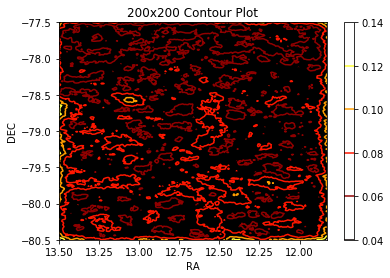

Total Runtime:  10.125962972640991 s
DistArray Defined


In [8]:
DistArray = distanceMap(200,data,20)

print('DistArray Defined')

Next, we define the function 'StarSelection' which will allow us to grab all stars located between individual contour lines. This version of the code chooses specific a specific contour at a certain level within the plot. You choose the region by simply inputting a RA and DEC. CrossHairs will appear on the plot illustrating where you are focusing your analysis. 

In [9]:
def StarSelection(distArray,RA,DEC,L,N):
    
    ## SPECIFY RA AND DEC RANGES
    RArange = RA
    DECrange = DEC
    
    fig, ax = plt.subplots()
    ax.set_facecolor('black')
    xgrid = np.linspace(np.min(data[:,0]),np.max(data[:,0]),N)
    ygrid = np.linspace(np.min(data[:,1]),np.max(data[:,1]),N)
    X, Y = np.meshgrid(xgrid,ygrid)
    X = np.array(X)
    Y = np.array(Y)
    cs = plt.contour(X,Y,distArray,5,alpha=1.0)
    plt.colorbar()
    plt.axvline(x=RArange,linestyle='--',color='y',alpha=0.6)
    plt.axhline(y=DECrange,linestyle='--',color='y',alpha=0.6)
    plt.xlim(np.min(X),np.max(X))
    plt.ylim(np.min(Y),np.max(Y))
    plt.gca().invert_xaxis()

    insideStars = []
    starCount = 0
    inside = []
    psize = 0
    for i in range(len(cs.collections[L].get_paths())):
        count = 0
        p = cs.collections[L].get_paths()[i]
        v = p.vertices
        x = v[:,0]
        y = v[:,1]
        if(RArange >= np.min(x) and RArange <= np.max(x) and DECrange >= np.min(y) and DECrange <= np.max(y)):
            count = count + 1
            polygon = v
            path = mpltPath.Path(polygon,closed=True)
            inside = path.contains_points(redData)
            coords = np.array([x,y])    
    for i in range(len(inside)):
        if(str(inside[i]) == 'True'):
            starCount = starCount + 1
            insideStars.append(redData[i])
    insideStars = np.array(insideStars)

    plt.scatter(redData[:,0],redData[:,1],s=1.0,c='orange',alpha=0.8)
    if(len(insideStars) > 0):
        plt.scatter(insideStars[:,0],insideStars[:,1],s=4.0,c='r')
        print('Total Stars within contour: ',starCount,'\n\n')
        plt.show()
    else:
        print('No stars located within selected contour')
        plt.show()
    

Now, here are examples using the Star Selection Function. 

Total Stars within contour:  9 




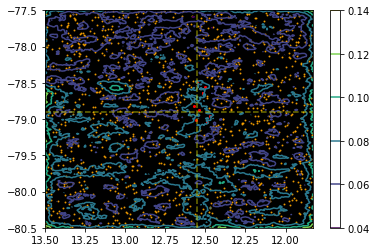

Total Stars within contour:  9 




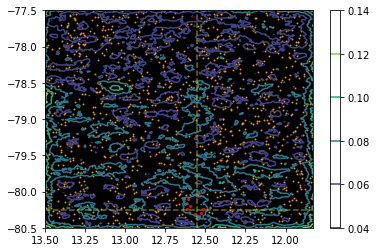

Total Stars within contour:  7 




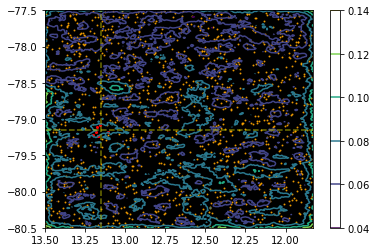

In [10]:

StarSelection(DistArray,12.55,-78.9,2,200)
StarSelection(DistArray,12.55,-80.25,2,200)
StarSelection(DistArray,13.15,-79.15,2,200)

Beware choosing a contour near the edge of the plot. These contours tend to not close in on themselves. When this happens, stars outside of the desired contour will also be selected. 
Here is an example:

Total Stars within contour:  1027 




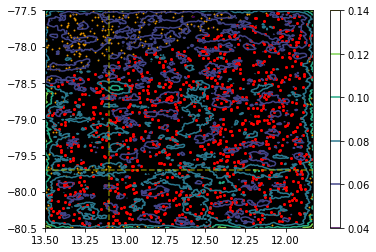

In [11]:
StarSelection(DistArray,13.10,-79.7,2,200)